### This is a realtively complex model, and Google Colaboratory only provides 12 hours of continuous runtime.
### Therefore, the model is trained in parts. 
### The first part contains the training, and the second part contains the evaluation

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Unzip Dataset

In [0]:
! unzip -q "drive/My Drive/Dataset_Upload/Dataset"

replace Dataset/Test/all.0_UID_1_1_1_all.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Import Dependencies

In [0]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from PIL import Image
import seaborn as sns
from matplotlib import style
import os

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

%matplotlib inline
style.use('fivethirtyeight')
sns.set(style = "whitegrid", color_codes = True)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
print(os.listdir("Dataset"))

['Train', 'Test']


### Set Image Dimensions

In [0]:
IMAGE_WIDTH = 450
IMAGE_HEIGHT = 450

IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

### If filename contains 'all', give it category = 1, otherwise give it category = 0

In [0]:
filenames = os.listdir("Dataset/Train")

categories = []

for filename in filenames:
    category = filename.split('.')[0]
    
    if category == 'all':
        categories.append(1)
    else:
        categories.append(0)
        
df = pd.DataFrame({'filename' : filenames, 'category' : categories})

In [0]:
df.head(10)

,filename,category
0,hem.UID_H14_15_10_hem.bmp,0
1,all.UID_2_28_1_all.bmp,1
2,all.0_UID_24_24_3_all.bmp,1
3,hem.1_UID_H20_4_1_hem.bmp,0
4,all.UID_25_4_8_all.bmp,1
5,all.0_UID_30_3_8_all.bmp,1
6,hem.UID_H12_24_3_hem.bmp,0
7,hem.0_UID_H12_4_4_hem.bmp,0
8,all.UID_15_25_1_all.bmp,1
9,hem.UID_H23_2_14_hem.bmp,0


In [0]:
df.tail(10)

,filename,category
19990,all.UID_24_11_6_all.bmp,1
19991,all.0_UID_34_10_1_all.bmp,1
19992,all.UID_26_19_3_all.bmp,1
19993,hem.0_UID_H24_29_6_hem.bmp,0
19994,all.0_UID_25_7_6_all.bmp,1
19995,all.UID_24_9_4_all.bmp,1
19996,all.0_UID_32_4_3_all.bmp,1
19997,hem.UID_H24_26_2_hem.bmp,0
19998,hem.1_UID_H1_5_1_hem.bmp,0
19999,hem.0_UID_H24_2_2_hem.bmp,0


Training set contains: 20000 samples


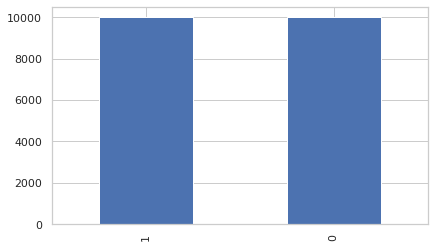

In [0]:
df['category'].value_counts().plot.bar()
print("Training set contains:", len(df), "samples")

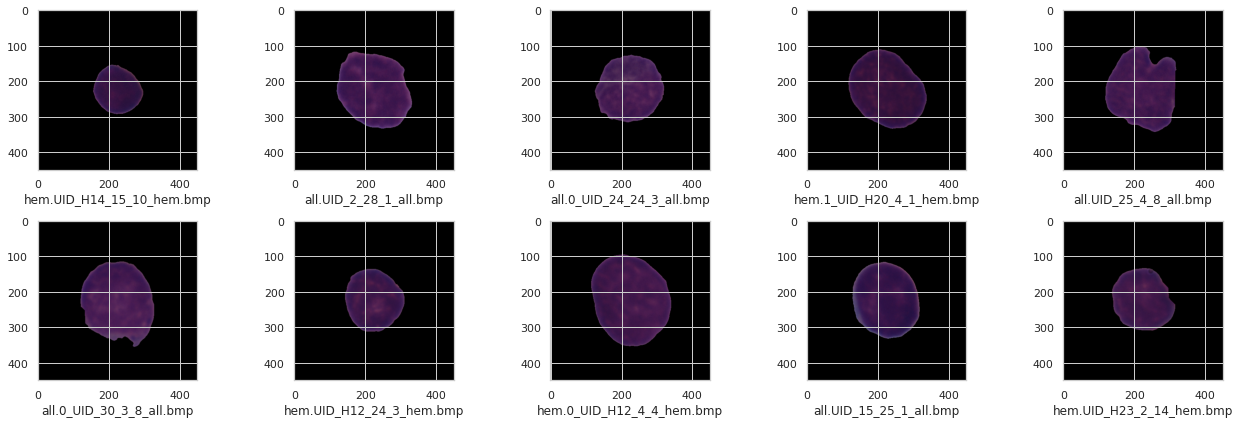

In [0]:
sample_train = df.head(10)
sample_train.head()

plt.figure(figsize = (18, 6))

for index, row in sample_train.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("Dataset/Train/" + filename, target_size = IMAGE_SIZE)
    plt.subplot(2, 5, index + 1)
    plt.imshow(img)
    plt.xlabel(filename)
    
plt.tight_layout()
plt.show()

In [0]:
df["category"] = df["category"].replace({0 : 'hem', 1 : 'all'})

#### Split the dataset into Train and Validation set

In [0]:
train_df, validate_df = train_test_split(df, test_size = 0.20, random_state = 42)

train_df = train_df.reset_index(drop = True)
validate_df = validate_df.reset_index(drop = True)


Training set contains 16000 samples


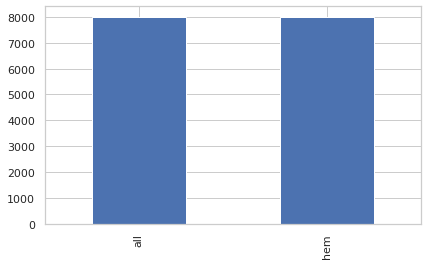

In [0]:
train_df['category'].value_counts().plot.bar()
print("\nTraining set contains", len(train_df), "samples")


Validation set contains 4000 samples


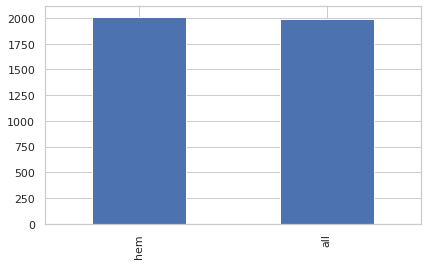

In [0]:
validate_df['category'].value_counts().plot.bar()
print("\nValidation set contains", len(validate_df), "samples")

In [0]:
batch_size = 16

In [0]:
train_datagen = ImageDataGenerator(
    rotation_range = 30,
    rescale = 1 / 255.0,
    shear_range = False,
    zoom_range = False,
    horizontal_flip = True,
    vertical_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

In [0]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "Dataset/Train",
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 16000 validated image filenames belonging to 2 classes.


In [0]:
validation_datagen = ImageDataGenerator(
    rotation_range = 30,
    rescale = 1 / 255.0,
    shear_range = False,
    zoom_range = False,
    horizontal_flip = True,
    vertical_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

In [0]:
validation_generator = train_datagen.flow_from_dataframe(
    validate_df,
    "Dataset/Train",
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 4000 validated image filenames belonging to 2 classes.


#### Example of ImageDataGenerator() 

Found 1 validated image filenames belonging to 1 classes.


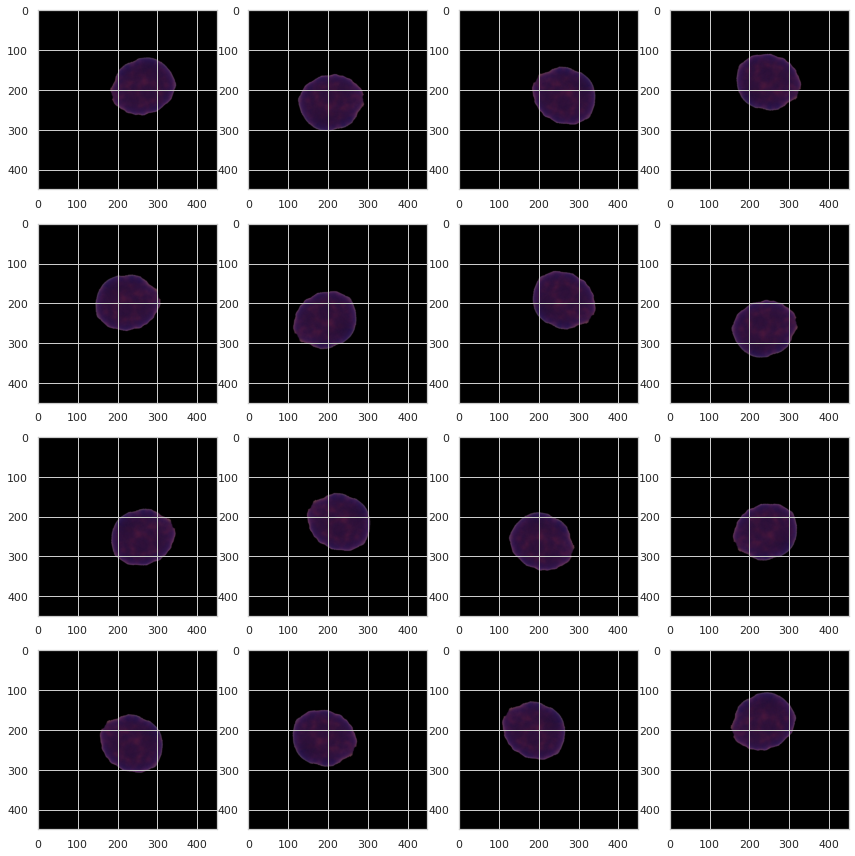

In [0]:
example_df = train_df.sample(n = 1).reset_index(drop = True)

example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "Dataset/Train",
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

plt.figure(figsize = (12, 12))

for i in range(0, 16):
    plt.subplot(4, 4, i + 1)
    
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break

plt.tight_layout()
plt.show()

In [0]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [0]:
model = Sequential()

model.add(Conv2D(input_shape = (450, 450, 3), filters = 64, kernel_size = (3, 3), padding = "same", activation = "relu"))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (3, 3)))

model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", activation = "relu"))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (3, 3)))

model.add(Conv2D(filters = 384, kernel_size = (3, 3), padding = "same", activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2), strides = (3, 3)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2), strides = (3, 3)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(units = 4096, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(units = 4096, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(units = 2, activation = "softmax"))

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr = 0.0001), metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 450, 450, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 256)     147712    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 384)       885120    
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 384)       1536      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 384)      

In [0]:
earlystop = EarlyStopping(monitor = "val_accuracy", patience = 10, verbose = 1)

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor = "val_accuracy", patience = 2, verbose = 1, factor = 0.5, min_lr = 0.00001)

In [0]:
checkpoint = ModelCheckpoint("allnet.h5", monitor = "val_accuracy", verbose = 1, save_best_only = True, mode = "auto")

In [0]:
callbacks = [earlystop, learning_rate_reduction, checkpoint]

In [0]:
epochs = 50

In [0]:
history = model.fit_generator(
    train_generator, 
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = total_validate // batch_size,
    steps_per_epoch = total_train // batch_size,
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/50
1000/1000 [==============================] - 1169s 1s/step - loss: 1.3235 - accuracy: 0.6496 - val_loss: 1.9424 - val_accuracy: 0.5048

Epoch 00001: val_accuracy improved from -inf to 0.50475, saving model to allnet.h5
Epoch 2/50
1000/1000 [==============================] - 1149s 1s/step - loss: 0.5765 - accuracy: 0.7296 - val_loss: 0.3812 - val_accuracy: 0.8020

Epoch 00002: val_accuracy improved from 0.50475 to 0.80200, saving model to allnet.h5
Epoch 3/50
1000/1000 [==============================] - 1157s 1s/step - loss: 0.5104 - accuracy: 0.7688 - val_loss: 0.5416 - val_accuracy: 0.6345

Epoch 00003: val_accuracy did not improve from 0.80200
Epoch 4/50
1000/1000 [==============================] - 1159s 1s/step - loss: 0.4309 - accuracy: 0.8094 - val_loss: 0.2931 - val_accuracy: 0.8363

Epoch 00004: val_accuracy improved from 0.80200 to 0.83625, saving model to allnet.h5
Epoch 5/50
 412/1000 [===========>..................] - ETA: 9:15 - loss: 0.3838 - accuracy: 0.8315

This model was trained for 28 epochs but I think I lost the output by accident

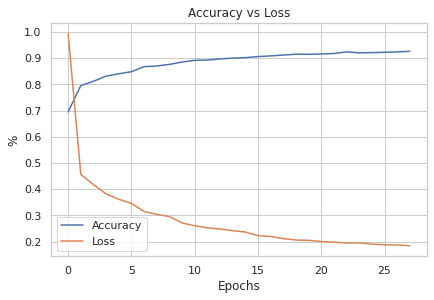

In [0]:
plt.plot(history.history['accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("%")

plt.show()

### Evaluation is done in part 2